In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer, f1_score, roc_auc_score
from sklearn import preprocessing
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
def concat_dataframes(path, df_type):
    dfs_list = []
    dfs_rows_len_list = []
    
    for user in os.listdir(path):
        for file in os.listdir(os.path.join(path, user)):
            if file.find(df_type) != -1:
                df = pd.read_csv(os.path.join(path, user, file))
                
                df = df.drop(["timestamp"], axis=1)
                df = (df - df.min()) / (df.max() - df.min())
                
                df["user"] = int(user.split('_')[1])
                
                dfs_list.append(df)
    
    return pd.concat(dfs_list, ignore_index=True)


def drop_bad_rows(df):
    bad_rows = set()
    for col in df.columns:
        if col != "user":
            for user in df.user.unique():
                for x in list(
                    df.loc[df.user == user, :][
                        np.abs(stats.zscore(df.loc[df.user == user, col])) > 3
                    ].index
                ):
                    bad_rows.add(x)

            for x in list(df[col][np.abs(stats.zscore(df[col])) > 3].index):
                bad_rows.add(x)

    df.drop(list(bad_rows), axis=0, inplace=True)

    return df


def print_bad_cols(df):
    bad_cols = set()
    for col in df.columns:
        if col != "user":
            if df[df[col] != df[col].mean()].shape[0] < 0.1 * df.shape[0]:
                bad_cols.add(col)

            for user in df.user.unique():
                if (
                    df.loc[df.user == user, :][
                        df.loc[df.user == user, col]
                        != df.loc[df.user == user, col].mean()
                    ].shape[0]
                    < 0.1 * df.loc[df.user == user, :].shape[0]
                ):
                    bad_cols.add(col)

                elif (
                    np.sum(np.abs(stats.zscore(df.loc[df.user == user, col])) < 3)
                    < 0.9 * df.loc[df.user == user, col].shape[0]
                ):
                    bad_cols.add(col)

    print(list(bad_cols))
    
    
def extract_delayed_user(df, user_label):
    df_user = df[df["user"] == user_label]
    df = df[df["user"] != user_label]
    return df_user, df


def split_users_into_two_classes(df, valid_user_label):
    df.loc[df["user"] != valid_user_label, "user"] = 0
    df.loc[df["user"] == valid_user_label, "user"] = 1
    return df  


def get_cv_split(X, y, group_labels, valid_user_label):
    predefined_split_array = np.zeros(group_labels.shape[0])
    i = 0
    test_array = [x for x in range(group_labels.shape[0])]
    for test, _ in LeaveOneGroupOut().split(X, y, group_labels):
        diff = np.setdiff1d(test_array, test)
        if np.all(group_labels[diff[0] : diff[-1]] == valid_user_label) is np.bool_(True):
            for sample in diff:
                predefined_split_array[sample] = -1
        else:
            for sample in diff:
                predefined_split_array[sample] = i
            i += 1
    return predefined_split_array


def generate_train_dataset(df, user, ex_user, is_SVM = False):
    df_ = df.copy()

    df_for_test = []

    df__ = df_[df_.labels == ex_user].copy()
    df_for_test.append(df__)
    df_ = df_.drop(df__.index, axis=0)

    for user_ in df_.labels.unique():
        if user_ != ex_user:
            test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
            df__ = df_[df_.labels == user_].sample(test_size).copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

    df_ = split_users_into_two_classes(df_.copy(), user)
          
    if is_SVM:    
        df_.loc[df_.user == 0, 'user'] = -1

    df_ = df_.drop("labels", axis=1)

    dataset = df_.to_numpy().copy()
    np.random.shuffle(dataset)

    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    return X, y, df_for_test


def generate_test_dataset(df_list, user, ex_user, is_SVM = False):
    test_df = pd.concat(df_list)

    valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
    ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
    others_in_test_count = [test_df[test_df.labels == x].shape[0]
                            for x in test_df.labels.unique() if x != user and x != ex_user]

    others_test_count = sum(others_in_test_count)
    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
    if others_test_count <= min(valid_user_in_test_count, ex_user_in_test_count):
        part_size = others_test_count    
        
    new_df_parts = []    

    new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
    new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())
    new_df_parts.append(test_df[~test_df.labels.isin([user, ex_user])].sample(part_size).copy())
    
    test_df = pd.concat(new_df_parts)
    
    test_df.loc[test_df.labels == user, "user"] = 1
    if is_SVM:
        test_df.loc[test_df.labels != user, "user"] = -1
    else:
        test_df.loc[test_df.labels != user, "user"] = 0

    print("True: ", test_df[test_df.user == 1].shape)
    print("Shape: ", test_df.shape)
    for x in test_df.labels.unique():
        print("Count ", x, ": ", test_df[test_df.labels == x].shape)

    test_df = test_df.drop("labels", axis=1)

    test_dataset = test_df.to_numpy().copy()
    X_test = test_dataset[:, :-1].copy()
    y_test = test_dataset[:, -1].copy()

    return X_test, y_test


def prepare_dataset(df, user, is_SVM=False):
    df_ = split_users_into_two_classes(df.copy(), user)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    if is_SVM:
        df_.loc[df_.user == 0, 'user'] = -1
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    return X, y, group_labels


def create_file_for_results(data_type):
    res_folder = '.\\_results'
    if os.path.exists(res_folder) is False:
        os.makedirs(res_folder)
    
    file = os.path.join(res_folder, data_type + '_results.json')
    if os.path.exists(file) is False:
        with open(file, 'w') as f:
            json.dump({'stub': None}, f)
        
    return file    


def update_file_with_results(file_path, results_dict):
    import collections.abc

    def update(d, u):
        for k, v in u.items():
            if isinstance(v, collections.abc.Mapping):
                d[k] = update(d.get(k, {}), v)
            else:
                d[k] = v
        return d
    
    with open(file_path, 'r') as f:
        res = json.load(f)
    
    res = update(res, results_dict)
    
    with open(file_path, 'w') as f:
        json.dump(res, f, sort_keys=True, indent=2)
        
        
def get_dict_with_results(json_path):
    with open(json_path, 'r') as f:
        res = json.load(f)
    return res    


def get_dataframe(path, data_type, window_type, window_size):
    return concat_dataframes(os.path.join(path, window_type, window_size), data_type), create_file_for_results(data_type)


def drop_corr_columns(df, corr_coef):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    corr_cols = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > corr_coef) and column != "user"]
    return df.drop(corr_cols, axis=1), corr_cols

In [3]:
df = concat_dataframes("..\\..\\scripts\\_features_all\\rolling\\60s", 'wifi')

In [4]:
features = df.columns.to_list()

In [5]:
df = df.drop(df.columns.difference(features), axis=1)
df = df.dropna(how='all')
df = df.fillna(0)

In [6]:
# df = drop_bad_rows(df)
print_bad_cols(df)

['occured_nets_count_median_mean', 'occur_speed_var_mad', 'jaccard_index_mean_mean', 'occured_nets_count_var_mad', 'occured_nets_count_var_mean', 'disappeared_nets_count_median_mean', 'jaccard_index_median_mean', 'level_speed_median_mad', 'occured_nets_count_mean_skew', 'jaccard_index_median_skew', 'occured_nets_count_mean_mean', 'occur_speed_median_skew', 'level_speed_var_mean', 'level_speed_mean_mean', 'disappeared_nets_count_mean_skew', 'jaccard_index_var_skew', 'occur_speed_mean_mad', 'occured_nets_count_mean_mad', 'occur_speed_var_skew', 'occur_speed_mean_mean', 'occur_speed_median_mad', 'occured_nets_count_median_mad', 'disappeared_nets_count_var_mean', 'occured_nets_count_median_skew', 'level_speed_var_skew', 'occur_speed_median_mean', 'disappeared_nets_count_median_mad', 'level_speed_median_skew', 'jaccard_index_var_mad', 'level_speed_mean_skew', 'occur_speed_mean_skew', 'level_speed_median_mean', 'disappeared_nets_count_var_skew', 'jaccard_index_mean_skew', 'level_speed_var_ma

In [7]:
# df, dropped_columns = drop_corr_columns(df, 0.7)

In [8]:
df['labels'] = df['user']

In [9]:
model_params = {
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'n_jobs': -1,
    'class_weight': 'balanced',
}

model = RandomForestClassifier(**model_params)

In [10]:
train_df = df[df['user'] != 8]
# train_df = df

In [11]:
df_ = train_df.copy()

df_for_test = []


df_ = split_users_into_two_classes(df_.copy(), 1)        
df_ = df_.drop("labels", axis=1)

dataset = df_.to_numpy().copy()
np.random.shuffle(dataset)

X = dataset[:, :-1]
y = dataset[:, -1]

In [12]:
model.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [13]:
test_df = pd.read_csv("..\\..\\scripts\\_feature_events\\15min\\rolling\\60s\\user_1\\wifi_0_0_8.data.csv")

In [15]:
# dropped_columns = [x for x in dropped_columns if x != 'labels']
test_df['user'] = test_df['user_user_agg']
# test_df = test_df.drop(dropped_columns, axis=1)
test_df = test_df.drop(['timestamp', 'user_user_agg', 'events_count_sum'], axis=1)
test_df = (test_df - test_df.min()) / (test_df.max() - test_df.min())

In [17]:
test_dataset = test_df.to_numpy().copy()

X_test = test_dataset[:, :-1]
y_test = test_dataset[:, -1]

In [18]:
predict = model.predict(X_test)
proba = model.predict_proba(X_test)

In [19]:
accuracy_score(y_test, predict)

0.1450381679389313

In [20]:
from sklearn import metrics

In [21]:
c = metrics.det_curve(y_test, proba[:, 1])

No handles with labels found to put in legend.


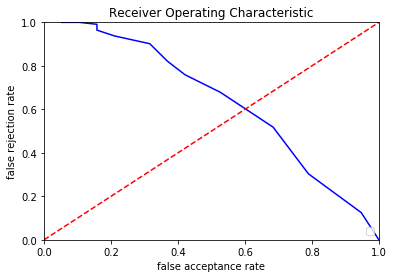

In [22]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(c[0], c[1], 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('false rejection rate')
plt.xlabel('false acceptance rate')
plt.show()